In [1]:
from sklearn.neural_network import MLPClassifier
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import accuracy_score,classification_report

In [2]:
data = pd.read_excel("SBMRawDump.xlsx")

In [3]:
data.head(1)


Case ID Issue Date      Time Contact Method     Full Name City State  \
0  1284734 2019-02-01  06:07:48  Inbound Email  Mr. Shane NA  NaN   NaN   

  ZIP/Post Code Reason Category        Reason Group  ...  \
0         00000         Request  Literature Request  ...   

      Marketing Segment Product Type Packaging Segment        Brand  \
0  Selective Herbicides  Concentrate            Bottle  BioAdvanced   

                                           Case Text  \
0  From Address: SBM <global_internal_communicati...   

                                             Product  Disposition  \
0  All in One Lawn Weed & Crabgrass Killer 32 oz ...  SDS Request   

         Level 1           Level 2            Level 3  
0  General Issue  Customer Request  Safety Data Sheet  

[1 rows x 26 columns]

In [4]:
data = data[1:5500]

In [5]:
data.dropna(inplace=True)
data.isnull().sum()

Case ID              0
Issue Date           0
Time                 0
Contact Method       0
Full Name            0
City                 0
State                0
ZIP/Post Code        0
Reason Category      0
Reason Group         0
Reason Code          0
Product Group        0
Product Subgroup     0
Product Section      0
Product Code         0
Brand Manager        0
Marketing Segment    0
Product Type         0
Packaging Segment    0
Brand                0
Case Text            0
Product              0
Disposition          0
Level 1              0
Level 2              0
Level 3              0
dtype: int64

In [6]:
text_data = data['Case Text']
label = data['Level 1']

In [7]:
cvec = CountVectorizer(stop_words = 'english')

In [8]:
cvec.fit(text_data)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [9]:
len(cvec.get_feature_names())

7036

In [10]:
print(len(label))

3698


In [11]:
label = label.map({'General Issue': 'General Issue','Product Issue': 'Product Issue','Pricing Issue':'others','Feedback':'others','Promotions':'others'})

In [12]:
label.value_counts()

General Issue    3118
Product Issue     449
others            131
Name: Level 1, dtype: int64

In [13]:
train_x, test_x , y_train, y_test = train_test_split(text_data,label)

In [14]:
y_train.value_counts()

General Issue    2349
Product Issue     326
others             98
Name: Level 1, dtype: int64

In [15]:
new = pd.DataFrame(list(zip(train_x,y_train)),columns=['text','label'])

In [16]:
new['label'].value_counts()

General Issue    2349
Product Issue     326
others             98
Name: label, dtype: int64

In [17]:
general_issue = new[new['label'] == 'General Issue']
product_issue = new[new['label'] == 'Product Issue']
others = new[new['label'] == 'others']

In [18]:
l = 500
print(l)

500


In [19]:
general_unsample = resample(general_issue,replace=True,n_samples = l,random_state = 123)
product_unsample = resample(product_issue,replace=True,n_samples = l,random_state = 123)
others_unsample = resample(others,replace=True,n_samples = l,random_state = 123)

In [20]:
data_unsample =  pd.concat([general_unsample,product_unsample,others_unsample]) #,feedback_unsampleproduct_issue_unsample

In [21]:
def display_by_group(data):
    x = data.groupby('label')['label'].count()
    plt.bar(x.keys(),x.to_list())

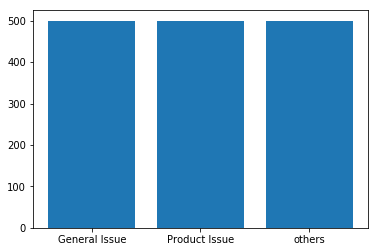

In [22]:
display_by_group(data_unsample)


In [23]:
train_x = data_unsample['text']
y_train = data_unsample['label']

In [24]:
X_train_cv = pd.DataFrame(cvec.transform(train_x).todense(),columns=cvec.get_feature_names())
X_test_cv = pd.DataFrame(cvec.transform(test_x).todense(),columns=cvec.get_feature_names())


In [25]:
clf = MLPClassifier( alpha=1e-5, hidden_layer_sizes=(4, 10), random_state=1)

In [26]:
clf.fit(X_train_cv,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [27]:
prediction = clf.predict(X_test_cv)

In [28]:
accuracy_score(y_test,prediction)

0.6475675675675676

In [29]:
print(classification_report(y_test,prediction))

               precision    recall  f1-score   support

General Issue       0.89      0.69      0.78       769
Product Issue       0.28      0.48      0.35       123
       others       0.07      0.24      0.11        33

    micro avg       0.65      0.65      0.65       925
    macro avg       0.41      0.47      0.41       925
 weighted avg       0.78      0.65      0.70       925

